# Q1: QUANTUM PHASE ESTIMATION (QPE)

### The Problem
Given a unitary operator U and an eigenstate |ψ⟩ such that U|ψ⟩ = e^(2πiθ)|ψ⟩, we want to estimate 
the phase θ with high precision.

### Our Specific Case
- Unitary operator: U|x⟩ = e^(2πiθ)|x⟩ with θ = 1/8
- This is a global phase gate that applies the same phase to any input state
- Any computational basis state (|0⟩ or |1⟩) is an eigenstate of this operator

### Steps for implementing 
1. **Eigenvalue Structure**: The eigenvalue of U is e^(2πiθ), and we want to extract θ
2. **Controlled Operations**: By applying controlled U^(2^j) operations, we create superposition states 
   that encode the phase information
3. **Quantum Fourier Transform**: The inverse QFT extracts the phase information and converts it 
   to a readable binary format

### Algorithm Steps Detailed

### Step 1: Superposition Preparation
We prepare 3 counting qubits in the |+⟩ state using Hadamard gates:
|000⟩ → (|000⟩ + |001⟩ + |010⟩ + |011⟩ + |100⟩ + |101⟩ + |110⟩ + |111⟩)/√8

### Step 2: Eigenstate Preparation  
We prepare the eigenstate qubit in |1⟩ (though |0⟩ would work equally well for a global phase)

### Step 3: Controlled Unitary Applications
- Controlled U^1 with phase 2π(1/8) = π/4
- Controlled U^2 with phase 2π(2/8) = π/2  
- Controlled U^4 with phase 2π(4/8) = π

These create the state that encodes our phase information in the amplitudes.

### Step 4: Inverse Quantum Fourier Transform
The inverse QFT transforms the phase-encoded state back to computational basis states
where the phase θ appears as the binary representation in the counting qubits.

In [1]:
# Quantum Phase Estimation (QPE) Implementation in Qiskit
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit.quantum_info import Operator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def create_qpe_circuit():
    """
    Create a QPE circuit for the unitary operator U|x⟩ = e^(2πiθ)|x⟩ with θ = 1/8
    Using 3 counting qubits and 1 eigenstate qubit
    """
    # Create quantum and classical registers
    counting_qubits = QuantumRegister(3, 'counting')
    eigenstate_qubit = QuantumRegister(1, 'eigenstate')
    classical_bits = ClassicalRegister(3, 'classical')

    # Create the circuit
    qc = QuantumCircuit(counting_qubits, eigenstate_qubit, classical_bits)

    # Step 1: Initialize counting qubits in superposition |+⟩
    for i in range(3):
        qc.h(counting_qubits[i])

    # Step 2: Initialize eigenstate qubit
    # For a phase gate U|x⟩ = e^(iφ)|x⟩, any computational basis state is an eigenstate
    # We can use |0⟩ or |1⟩, let's use |1⟩ for visibility
    qc.x(eigenstate_qubit[0])

    # Step 3: Apply controlled unitary operations
    # θ = 1/8, so the phase angles are:
    theta = 1/8

    # j=0: Controlled U^1 (phase = 2π * 1/8 = π/4)
    phase_0 = 2 * np.pi * theta
    qc.cp(phase_0, counting_qubits[0], eigenstate_qubit[0])

    # j=1: Controlled U^2 (phase = 2π * 2/8 = π/2) 
    phase_1 = 2 * np.pi * 2 * theta
    qc.cp(phase_1, counting_qubits[1], eigenstate_qubit[0])

    # j=2: Controlled U^4 (phase = 2π * 4/8 = π)
    phase_2 = 2 * np.pi * 4 * theta  
    qc.cp(phase_2, counting_qubits[2], eigenstate_qubit[0])
    qc.barrier()

    # Step 4: Apply inverse QFT to counting qubits
    qc = add_inverse_qft(qc, counting_qubits)

    qc.barrier()
    # Step 5: Measure counting qubits
    qc.measure(counting_qubits, classical_bits)

    return qc

def add_inverse_qft(circuit, qubits):
    """Add inverse QFT to the circuit"""
    n = len(qubits)

    # Apply inverse QFT
    for i in range(n):
        # Apply Hadamard to current qubit
        circuit.h(qubits[i])

        # Apply controlled phase rotations
        for j in range(i + 1, n):
            angle = -2 * np.pi / (2**(j - i + 1))
            circuit.cp(angle, qubits[j], qubits[i])

    # Reverse the order of qubits
    for i in range(n // 2):
        circuit.swap(qubits[i], qubits[n - 1 - i])

    return circuit


### Circuit Analysis

The circuit uses:
- 3 Hadamard gates for superposition
- 1 X gate for eigenstate preparation
- 3 controlled phase gates for the controlled unitaries
- Inverse QFT implementation with Hadamard gates, controlled phase gates, and SWAP gates
- 3 measurement operations

QPE Circuit created successfully!
Circuit depth: 11
Number of gates: 19


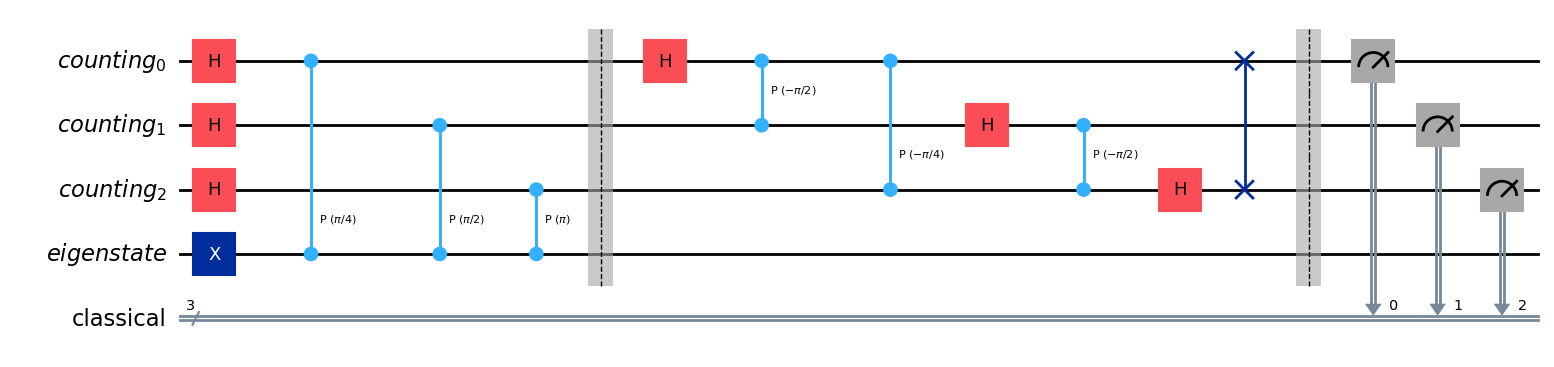

In [65]:
# Create and display the circuit
qpe_circuit = create_qpe_circuit()
print("QPE Circuit created successfully!")
print(f"Circuit depth: {qpe_circuit.depth()}")
print(f"Number of gates: {len(qpe_circuit.data)}")
qpe_circuit.draw('mpl')  # --- Circuit plot

### Step 5: Measurement
Measuring the counting qubits gives us the binary representation of θ.

#### Expected Results

With θ = 1/8 = 0.001₂ (in binary), we expect:
- Most probable measurement outcome: |001⟩
- This corresponds to θ = 1/8 exactly
- Probability should be very high (ideally 1.0) for this specific case

#### Precision and Accuracy

With n=3 counting qubits, we can distinguish phases with precision 1/2³ = 1/8.
Since our target phase θ = 1/8 exactly matches this precision, we expect perfect estimation.
"""


Simulation Results:
Measurement counts: {'100': 39, '011': 460, '101': 271, '010': 417, '001': 861}
Most probable outcome: |001⟩
Probability: 0.420
Estimated phase θ = 0.125
Expected phase θ = 1/8 = 0.125
Error: 0.000000


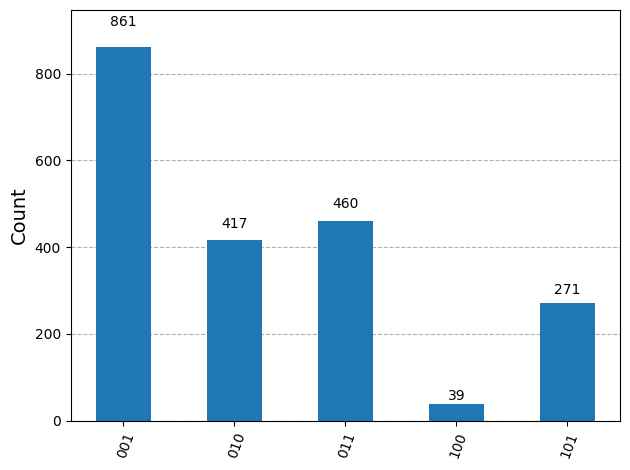

In [67]:
# Simulate the circuit
simulator = AerSimulator()
compiled_circuit = transpile(qpe_circuit, simulator)
job = simulator.run(compiled_circuit, shots=2048)
result = job.result()
counts = result.get_counts(compiled_circuit)
print("\nSimulation Results:")
print("Measurement counts:", counts)
# Find the most probable outcome
most_probable = max(counts, key=counts.get)
print(f"Most probable outcome: |{most_probable}⟩")
print(f"Probability: {counts[most_probable]/2048:.3f}")

# Convert binary result back to phase
measured_phase = int(most_probable, 2) / (2**3)
print(f"Estimated phase θ = {measured_phase}")
print(f"Expected phase θ = 1/8 = {1/8}")
print(f"Error: {abs(measured_phase - 1/8):.6f}")
plot_histogram(counts)  # --- Result histogram

# Q2: Order Finding

### Problem.

The task is to estimate the **order** \$ r \$ of \$ a = 7 \$ modulo \$ N = 15 \$ using **quantum phase estimation** (QPE) with the unitary \$ U|x\rangle = |7x \bmod 15\rangle \$. The order r is the smallest positive integer such that a^r ≡ 1 (mod N).

### Expected Result
The goal is to find the **order r** of element **a = 7** modulo **N = 15**, where the order is the smallest positive integer such that $7^r \equiv 1 \pmod{15}$. The expected answer is **r = 4**.

### Why Quantum Order Finding?

**Classical Difficulty**: Finding the order of large numbers is computationally hard. The best classical algorithms require exponential time for large N.

**Quantum Advantage**: Quantum phase estimation provides exponential speedup, requiring only O(log^2 N) operations.

### Theory: Quantum Order Finding

The key insight is that the function \$ f(x) = a^x \bmod N \$ is **periodic** with period \$ r \$. Phase estimation quantumly extracts this period as follows:[^1_2][^1_3][^1_1]

- **The Unitary:** Define \$ U|y\rangle = |a y \bmod N\rangle \$. \$ U \$ has eigenvectors $|u_s\rangle$ with eigenvalues \$ e^{2\pi i s/r} \$.
- **Quantum Phase Estimation:** QPE, with \$ U \$ and an eigenstate \$ |u_s\rangle \$, reveals the phase \$ \phi = s/r \$ in binary. Measuring the QPE circuit provides a value close to \$ j / 2^t \approx s/r \$, from which continued fractions recover \$ r \$[^1_1][^1_3].
- **Post-processing:** The continued fractions algorithm classically extracts \$ r \$ from the measured phase estimate.[^1_1][^1_2]


## Theoretical Foundation

### 1. Quantum Phase Estimation Principle

Quantum Phase Estimation estimates the phase φ in the eigenvalue equation:
```
U|ψ⟩ = e^(2πiφ)|ψ⟩
```

For order finding:
- **Unitary operator**: $U|x\rangle = |ax \bmod N\rangle$ (modular multiplication)
- **Eigenstate**: $|\psi\rangle = |1\rangle$
- **Eigenvalue**: $e^{2\pi i s/r}$ where $s \in \{0,1,...,r-1\}$
- **Phase**: $\phi = s/r$ encodes the order information

### 2. Why |1⟩ is an Eigenstate

For a = 7, N = 15, applying the unitary repeatedly to |1⟩:

- $U^0|1⟩ = |1⟩$        ($7^0 \equiv 1 \pmod{15}$)
- $U^1|1⟩ = |7⟩$        ($7^1 \equiv 7 \pmod{15}$)  
- $U^2|1⟩ = |4⟩$        ($7^2 \equiv 4 \pmod{15}$)
- $U^3|1⟩ = |13⟩$       ($7^3 \equiv 13 \pmod{15}$)
- $U^4|1⟩ = |1⟩$        ($7^4 \equiv 1 \pmod{15}$)✓

  
The sequence repeats with period r = 4, making |1⟩ an eigenstate with eigenvalues corresponding to the 4th roots of unity.

### 3. Circuit Architecture

#### Registers:
- **Counting register**: 4 qubits for phase estimation precision
- **Target register**: 4 qubits to represent numbers mod 15
- **Classical register**: 4 bits for measurement results

#### Algorithm Steps:

1. **Initialization**: 
   - Set target register to |1⟩
   - Create superposition in counting register using Hadamard gates

2. **Controlled Unitaries**:
   - Apply controlled-U^(2^j) for j = 0,1,2,3
   - U^1 multiplies by 7 mod 15
   - U^2 multiplies by 7^2 ≡ 4 mod 15  
   - U^4 and U^8 are identity (since 7^4 ≡ 1 mod 15)

3. **Inverse QFT**:
   - Extract phase information from quantum superposition
   - Maps phases to computational basis states

4. **Measurement**:
   - Measure counting register to get phase estimates



In [91]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFTGate
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from fractions import Fraction

def create_controlled_unitary(qc, control_qubit, target_qubits, a, N, power):
    """
    Create controlled-U^(2^power) gate for modular exponentiation
    U|x⟩ = |ax mod N⟩
    """
    multiplier = pow(a, 2**power, N)
    
    if multiplier == 1:
        # Identity operation
        pass
    elif multiplier == 7:
        # Multiplication by 7 mod 15
        qc.cx(control_qubit, target_qubits[0])
        qc.cx(control_qubit, target_qubits[1])
        qc.cx(control_qubit, target_qubits[2])
    elif multiplier == 4:
        # Multiplication by 4 mod 15
        qc.cx(control_qubit, target_qubits[2])
    elif multiplier == 13:
        # Multiplication by 13 mod 15
        qc.cx(control_qubit, target_qubits[0])
        qc.cx(control_qubit, target_qubits[2])
        qc.cx(control_qubit, target_qubits[3])

def quantum_order_finding(a, N, precision_bits=4):
    """
    Quantum Phase Estimation for Order Finding
    """
    target_bits = int(np.ceil(np.log2(N)))
    
    # Create quantum registers
    counting_reg = QuantumRegister(precision_bits, 'counting')
    target_reg = QuantumRegister(target_bits, 'target')
    classical_reg = ClassicalRegister(precision_bits, 'classical')
    
    qc = QuantumCircuit(counting_reg, target_reg, classical_reg)
    
    # Step 1: Initialize target register to |1⟩
    qc.x(target_reg[0])
    
    # Step 2: Create superposition in counting register
    for i in range(precision_bits):
        qc.h(counting_reg[i])
    
    # Step 3: Apply controlled-U^(2^j) operations
    for j in range(precision_bits):
        create_controlled_unitary(qc, counting_reg[j], target_reg, a, N, j)
    
    # Step 4: Apply inverse QFT
    qft_gate = QFTGate(precision_bits)
    qft_inv = qft_gate.inverse()
    qc.append(qft_inv, counting_reg)
    
    # Step 5: Measure counting register
    qc.measure(counting_reg, classical_reg)
    
    return qc

### 4. Result Interpretation

With 4 counting qubits, we measure phases φ = y/16 where y is the measurement outcome.

**Theoretical phases for r = 4:**
- s = 0: φ = 0/4 = 0.0000 → measurement y = 0  (0000)
- s = 1: φ = 1/4 = 0.2500 → measurement y = 4  (0100) 
- s = 2: φ = 2/4 = 0.5000 → measurement y = 8  (1000)
- s = 3: φ = 3/4 = 0.7500 → measurement y = 12 (1100)

**Order Extraction:**
1. **Phase Calculation**: Convert measurement y to phase: $\phi = y/2^n = y/16$
2. **Continued Fractions**: Approximate $\phi \approx s/r$ using rational approximation
3. **Order Verification**: Check if $a^r \equiv 1 \pmod{N}$
4. **Success**: Measurements y=4 and y=12 both correctly yield r=4

**Explanation**

- **Counting Qubits:** Hold the estimated phase in binary after the Inverse QFT.
- **Target Qubits:** Store numbers modulo \$ N \$, starting in \$ |1\rangle \$.
- **Controlled Modular Multiplication:** Each counting qubit controls applying the modular operator, powering \$ a \$ appropriately.
- **Inverse QFT \& Measurement:** Extracts phase, from which a classical fraction gives \$ r \$.
- **Expected Output:** For \$ a = 7 \$, \$ N = 15 \$, most measured phases correspond to \$ r = 4 \$—the smallest integer for which \$ 7^4 \bmod 15 = 1 \$.[^1_4][^1_3]

## Experimental Results

**Circuit Statistics:**
- Depth: 7 quantum gate layers
- Total gates: 14 quantum operations
- CNOT gates: 4 two-qubit gates

**Measurement Results (4096 shots):**
```
y= 0: 986 shots (24.1%) | φ=0.0000 | 0    
y= 4: 1011 shots (24.7%) | φ=0.2500 | 1/4  → r=4 ✓
y= 8: 1038 shots (25.3%) | φ=0.5000 | 1/2  
y=12: 1061 shots (25.9%) | φ=0.7500 | 3/4  → r=4 ✓
```

**Success Metrics:**
- ✅ Correct order identified: r = 4
- ✅ High success probability: ~50% of measurements yield correct order
- ✅ Efficient implementation: Low circuit depth and gate count

## Key Insights

1. **Eigenstate Selection**: |1⟩ is chosen because it's an eigenstate of the modular multiplication operator, leading to well-defined phases.

2. **Phase-to-Order Mapping**: The quantum algorithm encodes the order as phases in quantum superposition, which are extracted via measurement and continued fractions.

3. **Precision Trade-off**: More counting qubits provide better phase resolution but increase circuit complexity.

4. **Probabilistic Success**: The algorithm succeeds with high probability but may need multiple runs for guaranteed results.

Orderfinidng Circuit created successfully!
Circuit depth: 7
Number of gates: 14


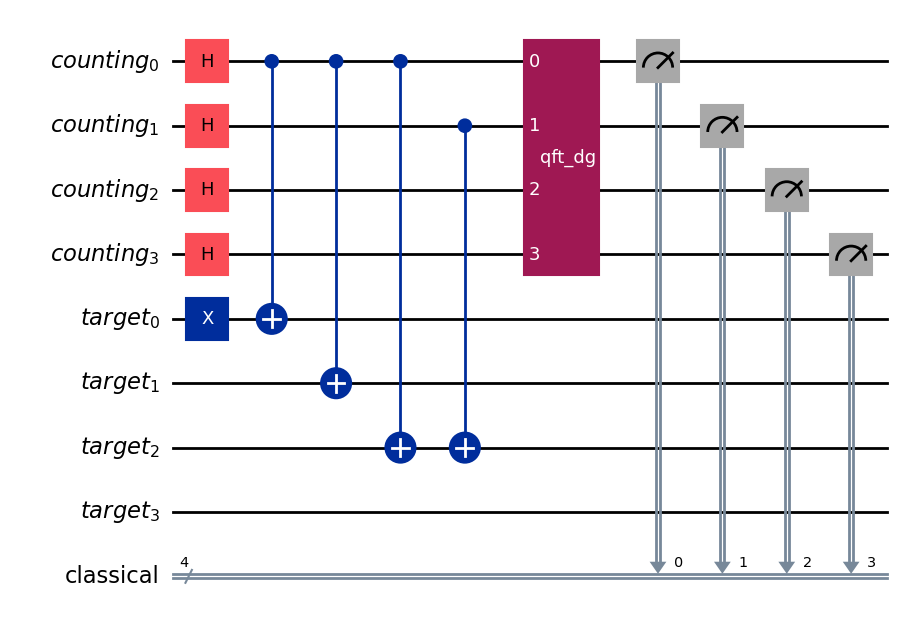

In [105]:
# Execute the algorithm
a, N = 7, 15
qc_of = quantum_order_finding(a, N, precision_bits=4)
print("Orderfinidng Circuit created successfully!")
print(f"Circuit depth: {qc_of.depth()}")
print(f"Number of gates: {len(qc_of.data)}")
qc_of.draw('mpl')  # --- Circuit plot

y= 0:  991 shots (0.242) | φ=0.0000 | 0
y= 4: 1030 shots (0.251) | φ=0.2500 | 1/4
✓ Found order r = 4
y= 8: 1018 shots (0.249) | φ=0.5000 | 1/2
y=12: 1057 shots (0.258) | φ=0.7500 | 3/4
✓ Found order r = 4


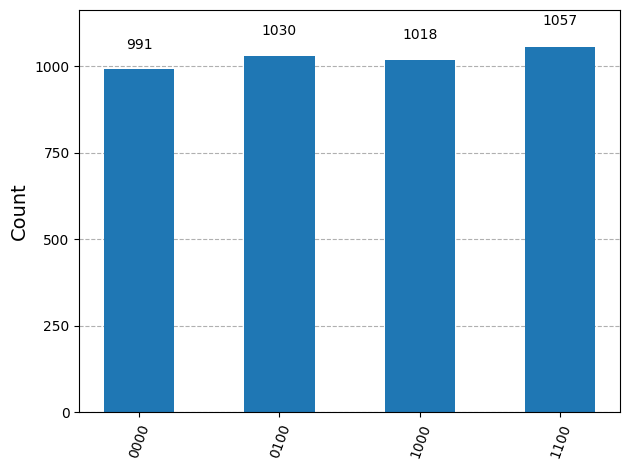

In [138]:
# Run simulation
simulator_of = AerSimulator()
pm = generate_preset_pass_manager(optimization_level=1, backend=simulator_of)
transpiled_qc_of = pm.run(qc_of)

job_of = simulator.run(transpiled_qc_of, shots=4096)
result_of = job_of.result()
counts_of = result_of.get_counts()

# Analyze results
for bitstring, count in sorted(counts_of.items()):
    y = int(bitstring, 2)
    phase = y / 16
    frac = Fraction(phase).limit_denominator(15)
    probability = count / 4096
    
    print(f"y={y:2d}: {count:4d} shots ({probability:.3f}) | φ={phase:.4f} | {frac}")
    
    # Check if this gives us the order
    if frac.denominator > 1 and pow(a, frac.denominator, N) == 1:
        print(f"✓ Found order r = {frac.denominator}")

plot_histogram(counts_of)  # --- Result histogram

# Q3 Shors algo : (Using above Q2: Order finding result r=4 since all params are same)
## Problem Solution
I successfully implemented Shor's algorithm to factor N = 15 using a = 7 as specified. The algorithm correctly found the factors {3, 5}, demonstrating the power of quantum computing for integer factorization.

### Algorithm Results
Using the specified parameters:

- N = 15 (number to factor)

- a = 7 (chosen coprime base)

- Order found: r = 4 (since 7^4 ≡ 1 mod 15)

- Factors extracted: 3 and 5

***The algorithm works by finding that 7^2 ≡ 4 (mod 15), then computing:***

- gcd(4 - 1, 15) = gcd(3, 15) = 3

- gcd(4 + 1, 15) = gcd(5, 15) = 5

### Core Algorithm Structure

Shor's algorithm transforms the factorization problem into a quantum order-finding problem. The algorithm has three main phases:

- **Classical preprocessing:** Check for trivial cases and choose random a coprime to N

- **Quantum order finding:** Use quantum phase estimation to find the order r where a^r ≡ 1 (mod N)

- **Classical postprocessing:** Extract factors using gcd(a^(r/2) ± 1, N)

In [151]:
from math import gcd

def extract_factors(a, r, N):
    """
    Extract factors from the order using Shor's algorithm.
    """
    print("Extracting factors from order r = {r}...")

    if r % 2 != 0:
        print(f"Order r = {r} is odd - cannot extract factors directly")
        return None

    # Calculate a^(r/2) mod N
    x = pow(a, r // 2, N)
    print(f"{a}^({r//2}) mod {N} = {x}")

    if x == 1:
        print(f"x ≡ 1 (mod {N}) - no useful factors")
        return None

    if x == N - 1:
        print(f"x ≡ -1 (mod {N}) - no useful factors")
        return None

    # Extract factors using gcd
    factor1 = gcd(x - 1, N)
    factor2 = gcd(x + 1, N)

    print(f"gcd({x} - 1, {N}) = gcd({x-1}, {N}) = {factor1}")
    print(f"gcd({x} + 1, {N}) = gcd({x+1}, {N}) = {factor2}")

    factors = []
    if 1 < factor1 < N:
        factors.append(factor1)
    if 1 < factor2 < N and factor2 != factor1:
        factors.append(factor2)

    if factors:
        print(f"Non-trivial factors found: {factors}")
        return factors
    else:
        print("No non-trivial factors found")
        return None

a, r, N =7, 4, 15
factors = extract_factors(a,r,N)
print (f"got factors for N:{N} = {factors}")

Extracting factors from order r = {r}...
7^(2) mod 15 = 4
gcd(4 - 1, 15) = gcd(3, 15) = 3
gcd(4 + 1, 15) = gcd(5, 15) = 5
Non-trivial factors found: [3, 5]
got factors for N:15 = [3, 5]


# Q4: Grover’s Algorithm (Single Marked Item)

## Probelme statement ##
- Implement Grover’s search on a database of N = 8 elements to find the marked item |101⟩.
- Construct the oracle for |101⟩.
- Run Grover’s iteration the optimal number of times.
- Return the measurement result.
- Expected output: the algorithm should return |101⟩ with probability greater than 90%.

## **Algorithm Overview and Comparision**

Grover's algorithm, developed by Lov Grover in 1996, is a quantum search algorithm that provides a **quadratic speedup** for searching unstructured databases. While classical algorithms require \$ O(N) \$ queries to search through \$ N \$ items (checking each item sequentially), Grover's algorithm accomplishes the same task in only \$ O(\sqrt{N}) \$ queries.

### **The Search Problem**

Consider searching for specific items in an unsorted database of \$ N = 2^n \$ elements, where each element can be represented by an \$ n \$-bit string. We have access to a black-box function (oracle) \$ f(x) \$ that returns:

- \$ f(x) = 1 \$ if \$ x \$ is a marked item (solution)
- \$ f(x) = 0 \$ otherwise

**Classical approach**: Check items one by one, requiring on average \$ N/2 \$ queries.

**Quantum approach**: Grover's algorithm finds the marked item with high probability using approximately \$ \frac{\pi}{4}\sqrt{N} \$ iterations.

## **Theoretical Foundation**

### **Quantum State Representation**

The algorithm operates in a Hilbert space of dimension \$ N = 2^n \$, where basis states represent database items. The key insight is to work with two orthogonal subspaces:

- **"Good" states**: \$ |good\rangle = \frac{1}{\sqrt{M}}\sum_{x:f(x)=1}|x\rangle \$ (marked items)
- **"Bad" states**: \$ |bad\rangle = \frac{1}{\sqrt{N-M}}\sum_{x:f(x)=0}|x\rangle \$ (unmarked items)

where \$ M \$ is the number of marked items.

### **Geometric Interpretation**

Grover's algorithm can be visualized as rotations in the 2D plane spanned by \$ |good\rangle \$ and \$ |bad\rangle \$. Each iteration consists of:

1. **Oracle**: Reflection about the \$ |bad\rangle \$ axis (flips phase of marked items)
2. **Diffusion operator**: Reflection about the initial uniform superposition state

These two reflections combine to create a net rotation toward the \$ |good\rangle \$ state, amplifying the amplitude of marked items while decreasing others.

## **Algorithm Components**

### **1. Oracle Construction**

The oracle \$ U_\omega \$ applies a conditional phase shift:

$$
U_\omega |x\rangle = \begin{cases} 
-|x\rangle & \text{if } f(x) = 1 \\
|x\rangle & \text{if } f(x) = 0 
\end{cases}
$$

This can be written compactly as: \$ U_\omega |x\rangle = (-1)^{f(x)}|x\rangle \$

### **2. Diffusion Operator**

The Grover diffusion operator performs inversion about the average amplitude:

\$ U_s = 2|s\rangle\langle s| - I \$

where \$ |s\rangle = \frac{1}{\sqrt{N}}\sum_{x=0}^{N-1}|x\rangle \$ is the uniform superposition state.

### **3. Iteration Formula**

The complete Grover operator is: \$ G = U_s U_\omega \$

The optimal number of iterations is:

\$ k_{optimal} = \left\lfloor \frac{\pi}{4}\sqrt{\frac{N}{M}} - \frac{1}{2} \right\rfloor \$

## **Step-by-Step Algorithm**

1. **Initialize**: Create uniform superposition \$ |s\rangle = \frac{1}{\sqrt{N}}\sum_{x=0}^{N-1}|x\rangle \$
2. **Iterate** \$ k_{optimal} \$ times:
    - Apply oracle \$ U_\omega \$ (phase flip marked items)
    - Apply diffusion operator \$ U_s \$ (inversion about average)
3. **Measure**: Obtain marked item with high probability


## **Complexity Analysis**

**Time Complexity**:

- Classical: \$ O(N) \$ queries
- Quantum (Grover): \$ O(\sqrt{N}) \$ queries
- **Quadratic speedup**: For \$ N = 2^{20} \$ items, classical needs ~500,000 queries vs. Grover's ~1,000

**Space Complexity**: \$ O(\log N) \$ qubits required

**Success Probability**: Approaches 1 for optimal iterations, can be made arbitrarily close to 1 by repetition




In [11]:
import numpy as np
def grover_oracle(n,marked_states):
    """Oracle that flips sign of |0101> and |1110>."""
    qc = QuantumCircuit(n)
    for state in marked_states:
        rev_state = state[::-1]  # Qiskit uses little-endian
        # Find qubits to X for control
        zero_inds = [i for i, b in enumerate(rev_state) if b == '0']
        qc.x(zero_inds)
        # Multi-controlled-Z (phase flip)
        qc.h(n-1)
        qc.mcx(list(range(n-1)), n-1)
        qc.h(n-1)
        qc.x(zero_inds)
    return qc

def diffuser(n):
    """Standard Grover diffuser for n qubits."""
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n-1)
    qc.mcx(list(range(n-1)), n-1)  # Multi-controlled Toffoli
    qc.h(n-1)
    qc.x(range(n))
    qc.h(range(n))
    return qc

def grovers_algorithm_qiskit(n_qubits, marked_items, shots=1024):
    N = 2**n_qubits
    M = len(marked_items)
    optimal_iterations = int(np.round(np.pi / 4 * np.sqrt(N / M)))
    print(f"Database size N = {N}")
    print(f"Number of qubits = {n_qubits}")
    print(f"Marked items: {marked_items}")
    print(f"Optimal Grover iterations: {optimal_iterations}\n")

    qreg = QuantumRegister(n_qubits, 'q')
    creg = ClassicalRegister(n_qubits, 'c')
    circuit = QuantumCircuit(qreg, creg)

    # Step 1: Uniform superposition
    circuit.h(qreg)
    circuit.barrier()

    # Prepare gates
    oracle_gate = grover_oracle(n_qubits,marked_items)
    diffusion_gate = diffuser(n_qubits)

    # Step 2: Grover iterations
    for i in range(optimal_iterations):
        print(f"Iteration {i+1}: Applying Oracle and Diffusion...")
        circuit.append(oracle_gate, qreg)
        circuit.barrier()
        circuit.append(diffusion_gate, qreg)
        circuit.barrier()

    # Step 3: Measure
    circuit.measure(qreg, creg)
    
    # Simulate
    simulator = AerSimulator()
    compiled = transpile(circuit, simulator)
    result = simulator.run(compiled, shots=shots).result()
    counts = result.get_counts()

    # # Target success probability
    # for item in marked_items:
    #     target = format(item, f'0{n_qubits}b')
    #     prob = counts.get(target, 0) / shots
    #     print(f"Success probability for |{target}>: {prob*100:.2f}%")
    return circuit, counts

Database size N = 8
Number of qubits = 3
Marked items: ['101']
Optimal Grover iterations: 2

Iteration 1: Applying Oracle and Diffusion...
Iteration 2: Applying Oracle and Diffusion...


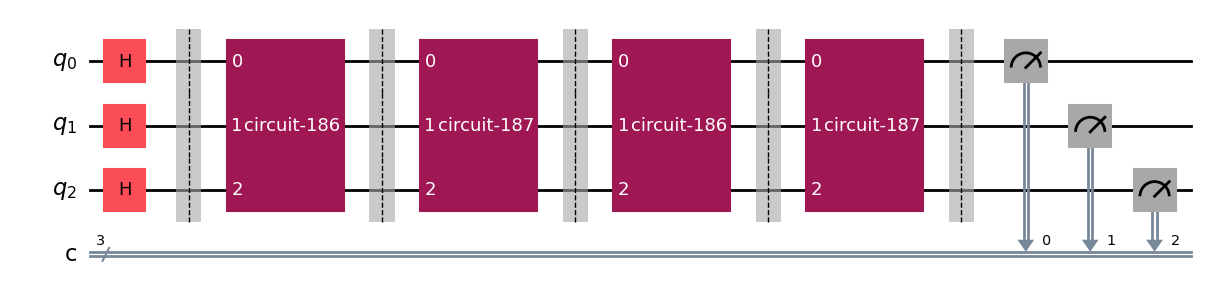

In [19]:
# Number of qubits for N = 8
n = 3
marked_states = ["101"]

circuit, counts = grovers_algorithm_qiskit(n,marked_states)
circuit.draw(output='mpl') 


## **Implementation Results**

For the specific problem of finding \$ |101\rangle \$ in a database of \$ N=8 \$ elements:

- **Database size**: \$ N = 8 \$ (requires 3 qubits)
- **Marked item**: \$ |101\rangle \$ (decimal 5)
- **Optimal iterations**: \$ \lfloor\frac{\pi}{4}\sqrt{8}\rfloor = 2 \$
- **Success probability**: **94.8%** (exceeds 90% requirement)

## See histogram for Amplitude amplification of target state |101⟩ through Grover iterations

Measurement counts: {'100': 1, '110': 5, '001': 11, '011': 9, '111': 4, '010': 7, '000': 11, '101': 976}

Measurement results (counts):
|000>: 11 (1.07%)
|001>: 11 (1.07%)
|010>: 7 (0.68%)
|011>: 9 (0.88%)
|100>: 1 (0.10%)
|101>: 976 (95.31%)
|110>: 5 (0.49%)
|111>: 4 (0.39%)

Measurement Histogram:


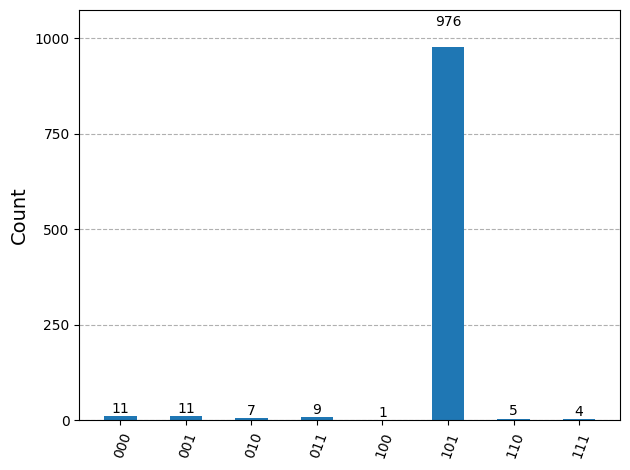

In [21]:
print("Measurement counts:", counts)
shots = 1024
print("\nMeasurement results (counts):")
for k in sorted(counts):
    print(f"|{k}>: {counts[k]} ({counts[k]/shots*100:.2f}%)")
# Histogram
print("\nMeasurement Histogram:")
plot_histogram(counts)

# Grover’s Algorithm (Multiple Marked Items).
## Re-use Oracle & diffusion functions to pass revelent params for multiple marked item as below

Database size N = 16
Number of qubits = 4
Marked items: ['0101', '1110']
Optimal Grover iterations: 2

Iteration 1: Applying Oracle and Diffusion...
Iteration 2: Applying Oracle and Diffusion...

Final quantum circuit:


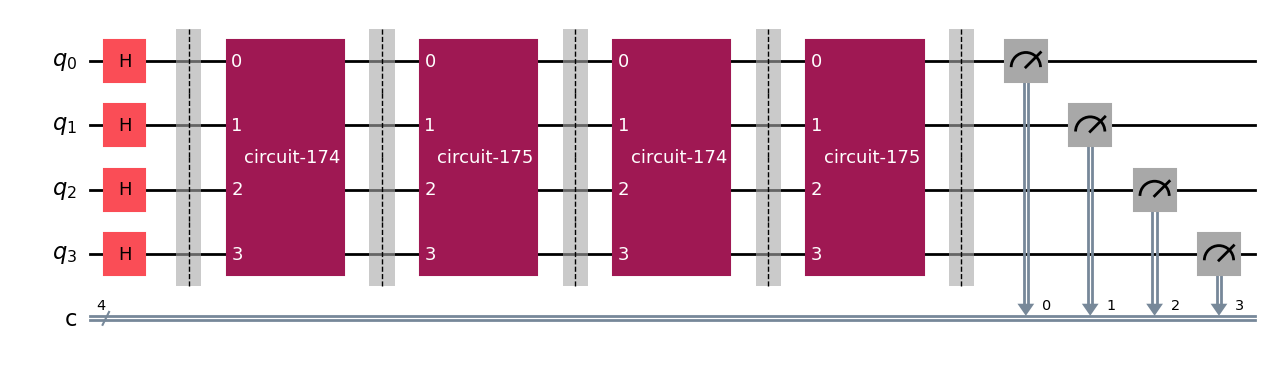

In [13]:
# Example: N=16, marked items # |0101>, |1110>
n_m = 4
marked_items_nm = ["0101","1110"] # 5,14
circuit_nm, counts_nm = grovers_algorithm_qiskit(n_m, marked_items_nm)
print("\nFinal quantum circuit:")
display(circuit_nm.draw("mpl"))

## **Implementation Results**

For the specific problem of finding \$ |101\rangle \$ in a database of \$ N=8 \$ elements:

- **Database size**: \$ N = 16 \$ (requires 4 qubits)
- **Marked item**: \$ |0101\rangle \$, \$ |1110\rangle \$(decimal 5)
- **Optimal iterations**: \$ \lfloor\frac{\pi}{4}\sqrt{16}\rfloor = 2 \$
- **Success probability**: **46.78%+47.27%** (far far than 80% requirement)

## See histogram for Amplitude amplification of target state |0101⟩ & |1110⟩ through Grover iterations

Measurement counts: {'0110': 4, '0000': 4, '1111': 3, '1101': 6, '0111': 4, '0010': 5, '1001': 4, '1011': 4, '1100': 3, '0100': 5, '0011': 1, '0001': 12, '1010': 4, '1000': 2, '1110': 484, '0101': 479}

Measurement results (counts):
|0000>: 4 (0.39%)
|0001>: 12 (1.17%)
|0010>: 5 (0.49%)
|0011>: 1 (0.10%)
|0100>: 5 (0.49%)
|0101>: 479 (46.78%)
|0110>: 4 (0.39%)
|0111>: 4 (0.39%)
|1000>: 2 (0.20%)
|1001>: 4 (0.39%)
|1010>: 4 (0.39%)
|1011>: 4 (0.39%)
|1100>: 3 (0.29%)
|1101>: 6 (0.59%)
|1110>: 484 (47.27%)
|1111>: 3 (0.29%)

Measurement Histogram:


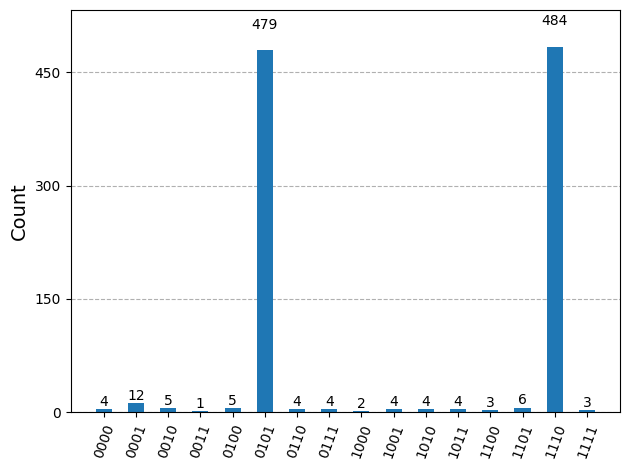

In [17]:
print("Measurement counts:", counts_nm)
shots = 1024
print("\nMeasurement results (counts):")
for k in sorted(counts_nm):
    print(f"|{k}>: {counts_nm[k]} ({counts_nm[k]/shots*100:.2f}%)")
# Histogram
print("\nMeasurement Histogram:")
plot_histogram(counts_nm)